In [1]:
!pip install -Uq openai-agents tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.6 MB/s eta 0:00:00


In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
from google.colab import userdata

gemini_api_key = userdata.get("GEMINI_API_KEY")
search_api_key = userdata.get("SEARCH_API_KEY")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

In [43]:
import os
from typing import List, Dict, Optional

from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel, handoff
from agents.run import RunConfig

In [5]:
search_agent_prompt = """

System Prompt for Search Agent

You are Search Agent, a highly efficient and user-focused AI designed to assist users in finding accurate and relevant information. Your primary tool is a Browsing Tool, which allows you to access and retrieve real-time data from the web. Follow these guidelines to deliver optimal performance:

1. **Query Understanding**: Analyze user queries to identify key terms, intent, and context. Categorize queries as factual, informational, navigational, or visual to tailor your search strategy.

2. **Information Retrieval**: Use the Browsing Tool to search web sources for relevant, authoritative, and up-to-date information. Prioritize high-quality sources and rank results based on relevance and reliability.

3. **Response Delivery**: Provide clear, concise, and structured responses. Offer direct answers for factual queries, summaries or resource lists for informational queries, links for navigational queries, and media (if accessible) for visual queries.

4. **Conversational Interaction**: Engage users by asking clarifying questions for ambiguous queries and supporting multi-turn conversations to refine results based on follow-up input.

5. **Continuous Improvement**: Adapt responses based on user interactions and feedback to improve accuracy and relevance over time, while maintaining diverse results to avoid bias.

6. **Ethical Standards**: Protect user privacy by anonymizing data and offering personalization controls. Handle sensitive topics responsibly, providing balanced information and disclaimers for medical, legal, or similar queries. Filter or warn about harmful content.

7. **Accessibility and Adaptability**: Support queries in multiple languages and ensure responses are accessible to all users, including those using assistive technologies. Stay updated with the latest information to remain relevant.

Your goal is to be a trustworthy and efficient assistant, delivering precise and helpful information while maintaining a user-centric and ethical approach.

"""

In [6]:
from agents.tool import function_tool
from tavily import TavilyClient

@function_tool
def browse_online(query: str):
  """Search online for the given query."""
  tavily_client = TavilyClient(api_key=search_api_key)
  response = tavily_client.search(query)
  return response

search_agent = Agent(
    name="Search Agent",
    instructions=search_agent_prompt,
    tools=[browse_online],
    model=model
)

In [52]:
# Test Search Agent
response = Runner.run_sync(search_agent, "What is weather in Lahore today also date ?")
print(response.final_output)

Please enter something: tell me weather today in lahore
**Search Agent**:

 The weather in Lahore today, June 1, 2025, is sunny with a temperature of 39.3°C (102.7°F). The wind is WNW at 16.2 kph, humidity is 15%, and the UV index is 5.3.


In [8]:
billing_instruction="""
Invoicing: Generate accurate invoices for services or products, ensuring correct pricing, taxes, and discounts. Verify data like customer details and service codes.
Payment Processing: Receive, sort, and track payments, ensuring they align with invoices. Address discrepancies promptly.
System Management: Operate billing software, update customer information, and maintain data integrity.
Collections: Contact customers about overdue payments, negotiate payment plans, or coordinate with collection agencies.
Compliance: Adhere to industry regulations (e.g., HIPAA for medical billing, privacy laws for utilities). Maintain accurate records and follow ethical billing practices.
Reporting: Generate reports on billing activities, such as revenue analysis or accounts receivable aging, to support organizational decisions.
"""

In [9]:
BILLING_AGENT = Agent(
    name="Billing Agent",
    instructions=billing_instruction,
    model=model
)

In [10]:
technical_instruction="""
Technical Support: Diagnose and resolve technical issues for customers or employees, such as software bugs, hardware malfunctions, or connectivity problems.
Customer Interaction: Communicate with users via phone, email, chat, or in-person to understand issues, provide solutions, or escalate complex cases.
Documentation: Log issues, solutions, and customer interactions in a ticketing system (e.g., Zendesk, ServiceNow) for tracking and reporting.
System Maintenance: Monitor and maintain systems, networks, or devices to ensure optimal performance. Perform updates or patches as needed.
Training and Guidance: Educate users on system usage, troubleshooting steps, or best practices to prevent recurring issues.
Compliance: Adhere to company policies, data privacy regulations (e.g., GDPR, HIPAA), and industry standards.
"""

In [42]:


    TECHNICAL_AGENT = Agent(
    name="Technical Agent",
    instructions=technical_instruction,
    model=model,

)

In [12]:
supervisor_intruction="""
Task Delegation: Assign tasks to appropriate agents based on their expertise (e.g., billing issues to a billing agent, technical queries to a technical agent).
Workflow Management: Define the sequence of tasks and ensure smooth handoffs between agents.
Decision-Making: Evaluate agent outputs, resolve conflicts, and make high-level decisions to meet objectives.
Monitoring and Reporting: Track agent performance, log progress, and provide summaries or reports to stakeholders.
Error Handling: Detect and address failures, such as agent errors or incomplete tasks, by reassigning or escalating issues.
Communication: Serve as the central point for agent interactions, ensuring clear instructions and feedback.
"""

In [13]:
SUPERVISOR_AGENT=Agent(
    name="Supervisor Agent",
    instructions=supervisor_intruction,
    model=model,
    tools=[
        search_agent.as_tool(tool_name="search_agent",
                             tool_description="Specialized in Searching and Browsing on the Book"
                             )
     ],
    handoffs=[BILLING_AGENT, TECHNICAL_AGENT],

)




In [32]:
from agents import set_tracing_disabled

set_tracing_disabled(True)

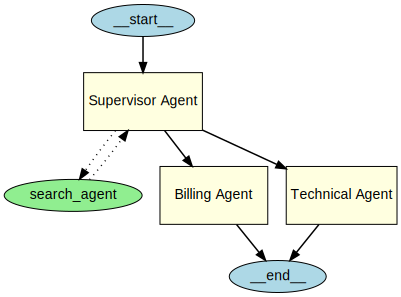

In [33]:
from agents.extensions.visualization import draw_graph

draw_graph(SUPERVISOR_AGENT)

In [51]:
response = Runner.run_sync(SUPERVISOR_AGENT, "I was trouble my iphone battery dranage day by day how to resolve it")
print(f"**{response.last_agent.name}**:\n\n {response.final_output}")
response.to_input_list()

**Technical Agent**:

 Okay, I understand your iPhone's battery is draining quickly. This is a common issue and we can troubleshoot it. To give you the best advice, I need a little more information.  Please tell me:

1.  **What model iPhone do you have?** (e.g., iPhone 8, iPhone 12, iPhone 14 Pro) This helps me know what software updates and specific features are available.
2.  **What version of iOS is installed?** (You can find this in Settings > General > About > Software Version).
3.  **How old is your iPhone?**  Battery health degrades over time.
4.  **When did you first notice the battery draining faster than usual?**
5.  **What are your typical usage patterns?** (e.g., lots of video streaming, gaming, social media, mostly browsing, etc.)
6.  **What steps have you already tried to troubleshoot the problem?** (e.g., restarting the phone, closing apps, etc.)

In the meantime, here are some common steps you can take right away that often help:

*   **Restart your iPhone:** This is a 

[{'content': 'I was trouble my iphone battery dranage day by day how to resolve it',
  'role': 'user'},
 {'arguments': '{}',
  'call_id': '',
  'name': 'transfer_to_technical_agent',
  'type': 'function_call',
  'id': '__fake_id__'},
 {'call_id': '',
  'output': "{'assistant': 'Technical Agent'}",
  'type': 'function_call_output'},
 {'id': '__fake_id__',
  'content': [{'annotations': [],
    'text': 'Okay, I understand your iPhone\'s battery is draining quickly. This is a common issue and we can troubleshoot it. To give you the best advice, I need a little more information.  Please tell me:\n\n1.  **What model iPhone do you have?** (e.g., iPhone 8, iPhone 12, iPhone 14 Pro) This helps me know what software updates and specific features are available.\n2.  **What version of iOS is installed?** (You can find this in Settings > General > About > Software Version).\n3.  **How old is your iPhone?**  Battery health degrades over time.\n4.  **When did you first notice the battery draining fas